In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/ADL/3/Pruning_filters_for_efficient_convnets-master

#Packages

In [ ]:
import os
import time
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import plot_confusion_matrix

#utils

In [ ]:
class AverageMeter(object):    
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_normalizer(data_set, inverse=False):
    if data_set == 'CIFAR10':
        MEAN = (0.4914, 0.4822, 0.4465)
        STD = (0.2023, 0.1994, 0.2010)

    elif data_set == 'CIFAR100':
        MEAN = (0.5071, 0.4867, 0.4408)
        STD = (0.2675, 0.2565, 0.2761)

    else:
        raise RuntimeError("Not expected data flag !!!")

    if inverse:
        MEAN = [-mean/std for mean, std in zip(MEAN, STD)]
        STD = [1/std for std in STD]

    return transforms.Normalize(MEAN, STD)

def get_transformer(data_set, imsize=None, cropsize=None, crop_padding=None, hflip=None):
    transformers = [] 
    if imsize:
        transformers.append(transforms.Resize(imsize))
    if cropsize:
        transformers.append(transforms.RandomCrop(cropsize, padding=crop_padding))
    if hflip:
        transformers.append(transforms.RandomHorizontalFlip(hflip))

    transformers.append(transforms.ToTensor())
    transformers.append(get_normalizer(data_set))
    
    return transforms.Compose(transformers)

def get_data_set(args, train_flag=True):
    if train_flag:
        data_set = torchvision.datasets.__dict__[args.data_set](root=args.data_path, train=True, 
                                       transform=get_transformer(args.data_set, args.imsize,
                                           args.cropsize, args.crop_padding, args.hflip), download=True)
    else:
        data_set = torchvision.datasets.__dict__[args.data_set](root=args.data_path, train=False, 
                                           transform=get_transformer(args.data_set), download=True)    
    return data_set

#Loss

In [ ]:
class Loss_Calculator(object):
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()        
        self.loss_seq = []
    
    def calc_loss(self, output, target):
        loss = self.criterion(output, target)        
        self.loss_seq.append(loss.item())
        return loss

    def get_loss_log(self, length=100):
        if len(self.loss_seq) < length:
            length = len(self.loss_seq)
        return sum(self.loss_seq[-length:])/length

#Network

In [ ]:
class VGG(torch.nn.Module):
    def __init__(self, vgg='vgg16_bn', data_set='CIFAR10', pretrained=False):
        super(VGG, self).__init__()
        self.features = models.__dict__[vgg](pretrained=pretrained).features
        
        classifier = []
        if 'CIFAR' in data_set:
            num_class = int(data_set.split("CIFAR")[1])
            
            classifier.append(torch.nn.Linear(512, 512))
            classifier.append(torch.nn.BatchNorm1d(512))
            classifier.append(torch.nn.Linear(512, num_class))
        else:
            raise RuntimeError("Not expected data flag !!!")

        self.classifier = torch.nn.Sequential(*classifier)
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

#optimizer

In [ ]:
def get_optimizer(network, args):
    optimizer = torch.optim.SGD(network.parameters(),
                                lr=args.lr, 
                                momentum=args.momentum, 
                                weight_decay=args.weight_decay)    

    scheduler = None
    if args.lr_milestone is not None:
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=args.lr_milestone, gamma=args.lr_gamma)

    return optimizer, scheduler

#Train

In [ ]:
def train_network(args, network=None, data_set=None):
    device = torch.device("cuda" if args.gpu_no >= 0 else "cpu")

    if network is None:
        network = VGG(args.vgg, args.data_set)
    network = network.to(device)

    if data_set is None:
        data_set = get_data_set(args, train_flag=True)
    
    loss_calculator = Loss_Calculator()
    
    optimizer, scheduler = get_optimizer(network, args)
    
    if args.resume_flag:
        check_point = torch.load(args.load_path)
        network.load_state_dict(check_point['state_dict'])
        loss_calculator.loss_seq = check_point['loss_seq']
        args.start_epoch = check_point['epoch']
                
    print("-*-"*10 + "\n\tTrain network\n" + "-*-"*10)
    for epoch in range(args.start_epoch, args.epoch):
        data_loader = torch.utils.data.DataLoader(data_set, batch_size=args.batch_size, shuffle=True)

        train_step(network, data_loader, loss_calculator, optimizer, device, epoch, args.print_freq)
        
        if scheduler is not None:
            scheduler.step()

        torch.save({'epoch': epoch+1, 
                   'state_dict': network.state_dict(),
                   'loss_seq': loss_calculator.loss_seq},
                   args.save_path+"check_point.pth")
        
    return network

def train_step(network, data_loader, loss_calculator, optimizer, device, epoch, print_freq=100):
    network.train()
    torch.backends.cudnn.benchmark = True
        
    data_time = AverageMeter()
    loss_time = AverageMeter()    
    forward_time = AverageMeter()
    backward_time = AverageMeter()
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    tic = time.time()
    for iteration, (inputs, targets) in enumerate(data_loader):
        data_time.update(time.time() - tic)
        
        inputs, targets = inputs.to(device), targets.to(device)
        tic = time.time()
        outputs = network(inputs)
        forward_time.update(time.time() - tic)
        
        tic = time.time()
        loss = loss_calculator.calc_loss(outputs, targets)
        loss_time.update(time.time() - tic)
        
        tic = time.time()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        backward_time.update(time.time() - tic)
        
        prec1, prec5 = accuracy(outputs.data, targets, topk=(1,5))
        top1.update(prec1.item(), inputs.size(0))
        top5.update(prec5.item(), inputs.size(0))
                        
        if iteration % print_freq == 0:
            logs_ = '%s: '%time.ctime()
            logs_ += 'Epoch [%d], '%epoch
            logs_ += 'Iteration [%d/%d/], '%(iteration, len(data_loader))
            logs_ += 'Data(s): %2.3f, Loss(s): %2.3f, '%(data_time.avg, loss_time.avg)
            logs_ += 'Forward(s): %2.3f, Backward(s): %2.3f, '%(forward_time.avg, backward_time.avg)
            logs_ += 'Top1: %2.3f, Top5: %2.4f, '%(top1.avg, top5.avg)
            logs_ += 'Loss: %2.3f'%loss_calculator.get_loss_log()
            print(logs_)            
                        
        tic = time.time()
    return None

#prune

In [ ]:
def prune_network(args, network=None):
    device = torch.device("cuda" if args.gpu_no >= 0 else "cpu")

    if network is None:
        network = VGG(args.vgg, args.data_set,pretrained=False)

    # prune network
    network = prune_step(network, args.prune_layers, args.prune_channels, args.independent_prune_flag)
    network = network.to(device)
    print("-*-"*10 + "\n\tPrune network\n" + "-*-"*10)
    print(network)

    if args.load_path:
        check_point = torch.load(args.load_path)
        network.load_state_dict(check_point['state_dict'])

    if args.retrain_flag:
        args.epoch = args.retrain_epoch
        args.lr = args.retrain_lr
        args.lr_milestone = None 

        network = train_network(args, network)

    return network

def prune_step(network, prune_layers, prune_channels, independent_prune_flag):
    network = network.cpu()

    count = 0 # count for indexing 'prune_channels'
    conv_count = 1 # conv count for 'indexing_prune_layers'
    dim = 0 # 0: prune corresponding dim of filter weight [out_ch, in_ch, k1, k2]
    residue = None 
    for i in range(len(network.features)):
        if isinstance(network.features[i], torch.nn.Conv2d):
            if dim == 1:
                new_, residue = get_new_conv(network.features[i], dim, channel_index, independent_prune_flag)
                network.features[i] = new_
                dim ^= 1

            if 'conv%d'%conv_count in prune_layers:         
                channel_index = get_channel_index(network.features[i].weight.data, prune_channels[count], residue)
                new_ = get_new_conv(network.features[i], dim, channel_index, independent_prune_flag)
                network.features[i] = new_
                dim ^= 1
                count += 1
            else:
                residue = None
            conv_count += 1

        elif dim == 1 and isinstance(network.features[i], torch.nn.BatchNorm2d):
            new_ = get_new_norm(network.features[i], channel_index)
            network.features[i] = new_

    if 'conv13' in prune_layers:
        network.classifier[0] = get_new_linear(network.classifier[0], channel_index)

    return network

def get_channel_index(kernel, num_elimination, residue=None):

    sum_of_kernel = torch.sum(torch.abs(kernel.view(kernel.size(0), -1)), dim=1)
    if residue is not None:
        sum_of_kernel += torch.sum(torch.abs(residue.view(residue.size(0), -1)), dim=1)
    
    vals, args = torch.sort(sum_of_kernel)

    return args[:num_elimination].tolist()

def index_remove(tensor, dim, index, removed=False):
    if tensor.is_cuda:
        tensor = tensor.cpu()
    size_ = list(tensor.size())
    new_size = tensor.size(dim) - len(index)
    size_[dim] = new_size
    new_size = size_

    select_index = list(set(range(tensor.size(dim))) - set(index))
    new_tensor = torch.index_select(tensor, dim, torch.tensor(select_index))
    
    if removed:
        return new_tensor, torch.index_select(tensor, dim, torch.tensor(index))

    return new_tensor

def get_new_conv(conv, dim, channel_index, independent_prune_flag=False):
    if dim == 0:
        new_conv = torch.nn.Conv2d(in_channels=conv.in_channels,
                                   out_channels=int(conv.out_channels - len(channel_index)),
                                   kernel_size=conv.kernel_size,
                                   stride=conv.stride, padding=conv.padding, dilation=conv.dilation)
        
        new_conv.weight.data = index_remove(conv.weight.data, dim, channel_index)
        new_conv.bias.data = index_remove(conv.bias.data, dim, channel_index)

        return new_conv

    elif dim == 1:
        new_conv = torch.nn.Conv2d(in_channels=int(conv.in_channels - len(channel_index)),
                                   out_channels=conv.out_channels,
                                   kernel_size=conv.kernel_size,
                                   stride=conv.stride, padding=conv.padding, dilation=conv.dilation)
        
        new_weight = index_remove(conv.weight.data, dim, channel_index, independent_prune_flag)
        residue = None
        if independent_prune_flag:
            new_weight, residue = new_weight
        new_conv.weight.data = new_weight
        new_conv.bias.data = conv.bias.data

        return new_conv, residue

def get_new_norm(norm, channel_index):
    new_norm = torch.nn.BatchNorm2d(num_features=int(norm.num_features - len(channel_index)),
                                    eps=norm.eps,
                                    momentum=norm.momentum,
                                    affine=norm.affine,
                                    track_running_stats=norm.track_running_stats)

    new_norm.weight.data = index_remove(norm.weight.data, 0, channel_index)
    new_norm.bias.data = index_remove(norm.bias.data, 0, channel_index)

    if norm.track_running_stats:
        new_norm.running_mean.data = index_remove(norm.running_mean.data, 0, channel_index)
        new_norm.running_var.data = index_remove(norm.running_var.data, 0, channel_index)
        
    return new_norm

def get_new_linear(linear, channel_index):
    new_linear = torch.nn.Linear(in_features=int(linear.in_features - len(channel_index)),
                                out_features=linear.out_features,
                                bias=linear.bias is not None)
    new_linear.weight.data = index_remove(linear.weight.data, 1, channel_index)
    new_linear.bias.data = linear.bias.data
    
    return new_linear

#Prune with cosine 

In [ ]:
def prune_network_cosine(args, network=None):
    device = torch.device("cuda" if args.gpu_no >= 0 else "cpu")

    if network is None:
        network = VGG(args.vgg, args.data_set,pretrained=False)
        
    # prune network
    network = prune_step(network, args.prune_layers, args.prune_channels, args.independent_prune_flag)
    network = network.to(device)
    print("-*-"*10 + "\n\tPrune network\n" + "-*-"*10)
    print(network)

    if args.load_path:
        check_point = torch.load(args.load_path)
        network.load_state_dict(check_point['state_dict'])

    network = prune_step_cosine(network, args.prune_layers_cosine, args.prune_channels_cosine, args.independent_prune_flag)
    network = network.to(device)
    print("-*-"*10 + "\n\tPrune network\n" + "-*-"*10)
    print(network)    

    if args.retrain_flag:
        args.epoch = args.retrain_epoch
        args.lr = args.retrain_lr
        args.lr_milestone = None 

        network = train_network(args, network)

    return network

def prune_step_cosine(network, prune_layers, prune_channels, independent_prune_flag):
    network = network.cpu()

    count = 0 # count for indexing 'prune_channels'
    conv_count = 1 # conv count for 'indexing_prune_layers'
    dim = 0 # 0: prune corresponding dim of filter weight [out_ch, in_ch, k1, k2]
    residue = None # residue is need to prune by 'independent strategy'
    for i in range(len(network.features)):
        if isinstance(network.features[i], torch.nn.Conv2d):
            if dim == 1:
              if len(channel_index)>0:
                new_, residue = get_new_conv(network.features[i], dim, channel_index, independent_prune_flag)
                network.features[i] = new_
                dim ^= 1

            if 'conv%d'%conv_count in prune_layers:         
                channel_index = get_channel_index_cosine(network.features[i].weight.data, prune_channels[count], residue)
                if len(channel_index)>0:
                  new_ = get_new_conv(network.features[i], dim, channel_index, independent_prune_flag)
                  network.features[i] = new_
                  dim ^= 1
                  count += 1
            else:
                residue = None
            conv_count += 1

        elif dim == 1 and isinstance(network.features[i], torch.nn.BatchNorm2d):
          if len(channel_index)>0:
            new_ = get_new_norm(network.features[i], channel_index)
            network.features[i] = new_

    if 'conv13' in prune_layers:
      if len(channel_index)>0:
        network.classifier[0] = get_new_linear(network.classifier[0], channel_index)

    return network

def get_channel_index_cosine(kernel, num_elimination, residue=None):

    kernel = kernel.view(kernel.size(0),-1)
    number_filt = kernel.size(0)
    norm = torch.norm(kernel,dim=1)
    index = []
    for i in range(number_filt):
      for j in range(i+1,number_filt):
          cosine = torch.sum(kernel[i]*kernel[j])/(norm[i]*norm[j])
          if cosine>0.8:
            index.append(i)
    index = set(index)
    print(f'Number of filter to prune:{len(index)}')
    return list(index)


#Evaluate

In [ ]:
def test_network(args, network=None, data_set=None):
    device = torch.device("cuda" if args.gpu_no >= 0 else "cpu")
    
    if network is None:
        network = VGG(args.vgg, args.data_set,pretrained=False)

    # prune network
    network = prune_step(network, args.prune_layers, args.prune_channels, args.independent_prune_flag)
    print("-*-"*10 + "\n\tPrune network\n" + "-*-"*10)
    print(network)

    if args.load_path:
        check_point = torch.load(args.load_path)
        network.load_state_dict(check_point['state_dict'])
    network.to(device)

    if data_set is None:
        data_set = get_data_set(args, train_flag=False)
    data_loader = torch.utils.data.DataLoader(data_set, batch_size=100, shuffle=False)

    top1, top5 = test_step(network, data_loader, device)
    
    return network, data_set, (top1, top5)
    
def test_step(network, data_loader, device):
    network.eval()
        
    data_time = AverageMeter()
    forward_time = AverageMeter()    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    with torch.no_grad():
        tic = time.time()
        for inputs, targets in data_loader:
            data_time.update(time.time() - tic)

            inputs, targets = inputs.to(device), targets.to(device)
            
            tic = time.time()
            outputs = network(inputs)
            forward_time.update(time.time() - tic)
            
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            tic = time.time()

    str_ = '%s: Test information, '%time.ctime()
    str_ += 'Data(s): %2.3f, Forward(s): %2.3f, '%(data_time.sum, forward_time.sum)
    str_ += 'Top1: %2.3f, Top5: %2.3f, '%(top1.avg, top5.avg)
    print("-*-"*10 + "\n\tEvalute network\n" + "-*-"*10)
    print(str_)
    
    return top1.avg, top5.avg

def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()

    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1,1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

#Hyperprameter

In [ ]:
class get_parameter():
    gpu_no = 0  #help='cpu: -1, gpu: 0 ~ n '

    train_flag = False  #help='flag for training  network'

    resume_flag = False  #help='flag for resume training'

    prune_flag = False  #help='flag for pruning network'

    retrain_flag = False #help='flag for retraining pruned network'

    retrain_epoch=30  #help='number of epoch for retraining pruned network'

    retrain_lr=0.001  #help='learning rate for retraining pruned network'

    data_set='CIFAR10'  #help='Data set for training network'

    data_path='../'   #help='Path of dataset'

    vgg='vgg16_bn'  #help='version of vgg network'
    
    start_epoch=0  #help='start epoch for training network'

    epoch =30   #help='number of epoch for training network'
    
    batch_size =128  #help='batch size'

    num_workers=2  #help='number of workers for data loader'

    lr = 0.01   #help='learning rate'

    lr_milestone =[150, 250]  #help='list of epoch for adjust learning rate'

    lr_gamma=0.1  #'factor for decay learning rate'

    momentum=0.9  #'momentum for optimizer'

    weight_decay=5e-4  #'factor for weight decay in optimizer'

    imsize=None  #'size for image resize'

    cropsize=32  #'size for image crop'

    crop_padding=4  #'size for padding in image crop'

    hflip=0.5  #probability of random horizontal flip

    print_freq = 100  #'print frequency during training
    load_path='./trained_models/pruning_results/check_point.pth'  #'trained model load path to prune'
    # load_path_cosine ='./trained_models/pruning_results_pruned_cosine/check_point.pth'  #'trained model load path to prune'
    # load_path = None
    save_path = './trained_models/pruning_results_independent/'  #'model save path'
    independent_prune_flag = False  #prune multiple layers by "independent strategy"
    prune_channels = [48, 256, 384, 384, 384, 384, 256] #layer index for pruning
    prune_channels_cosine = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512] #layer index for pruning with cosine
    prune_layers = ['conv1', 'conv8', 'conv9', 'conv10', 'conv11', 'conv12', 'conv13'] #number of channel to prune layers
    prune_layers_cosine = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'conv7', 'conv8', 'conv9', 'conv10', 'conv11', 'conv12', 'conv13'] #number of channel to prune layers with cosine

#main

In [ ]:
args = get_parameter()

os.environ['CUDA_VISIBLE_DEVICES'] = str(args.gpu_no)

if not os.path.exists(args.save_path):
    os.makedirs(args.save_path)

torch.save(args, args.save_path+"arguments.pth")

In [ ]:
network = None
if args.train_flag:
    network = train_network(args, network=network)

if args.prune_flag:
    network = prune_network_cosine(args, network=network)

test_network(args, network=network)

#Normalised filter value

Files already downloaded and verified
-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Mon Feb  1 11:53:54 2021: Test information, Data(s): 1.722, Forward(s): 0.323, Top1: 92.300, Top5: 99.570, 


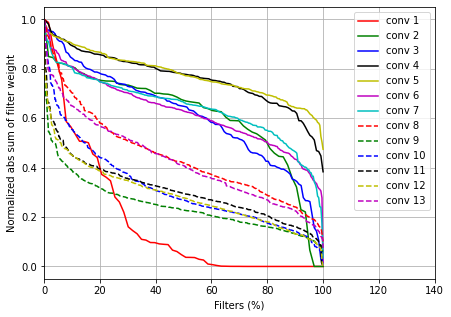

In [ ]:
network, test_set, (top1, top5) = test_network(args)

colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
lines = ['-', '--', '-.']

plt.figure(figsize=(7,5))
conv_count = 0
for layer in network.features:
    if isinstance(layer, torch.nn.Conv2d):
        line_style = colors[conv_count%len(colors)] + lines[conv_count//len(colors)]
        
        fw = layer.weight.data.cpu().numpy()
        
        sorted_abs_sum = np.sort(np.sum(np.abs(fw.reshape(fw.shape[0], -1)), axis=1))[::-1]

        normalized_abs_sum = sorted_abs_sum/sorted_abs_sum[0]
        conv_count += 1
        plt.plot(np.linspace(0, 100, normalized_abs_sum.shape[0]), normalized_abs_sum, line_style, label='conv %d'%conv_count)
        
plt.ylabel("Normalized abs sum of filter weight")
plt.xlabel("Filters (%)")
plt.legend(loc='upper right')
plt.xlim([0, 140])
plt.grid()
plt.savefig("figure2.png", dpi=150, bbox_inches='tight')
plt.show()

#Plot Filters

In [ ]:
k = 0
f, axarr = plt.subplots(12,11)
for i in range(12):
  for j in range(11):
    if k<128:
      axarr[i,j].imshow(network.features[40].weight[1,k,:,:].cpu().detach())
    axarr[i,j].axis('off')
    k+=1

#Parameter

In [ ]:
params_train = sum(p.numel() for p in network.parameters() if p.requires_grad)
print(params_train)